# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [1]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def reprojectImageTo3d(disparity,Q):
    h,w = disparity.shape
    disparity_map = []
    for i in range(h):
        for j in range(w):
            disparity_map.append([j,i,disparity[i,j],1])
    points = []
    for dis in disparity_map:
        point = Q @ dis
        points.append(point)
    return np.array(points)

def find_disparity(imageL,imageR):
    stereo = cv2.StereoSGBM_create(minDisparity = -39,
        numDisparities = 144,
        disp12MaxDiff = 1,
        blockSize=5,
        P1= 8*3* 5**2,
        P2= 32*3*5**2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap= 63
        )
    disparity = stereo.compute(imageL, imageR).astype(np.float32)/64.0
    disparity = (disparity+39)/144
    return disparity

In [3]:
f = open('../data/poses.txt', 'r')
poses = np.loadtxt(f)
poses = poses.reshape(len(poses),3,4)
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
              [0.000000e+00, 7.070912e+02, 1.831104e+02],
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
f = K[0,0]
b = 0.53790448812
pcd = o3d.geometry.PointCloud()
combined_pcd = o3d.geometry.PointCloud()
h, w = [370, 1226] # Got from image shape
Q = np.array([[1, 0, 0, -w/2], [0, -1, 0, h/2], [0, 0, 0, f], [0, 0, 1/b, 0]])
m_start = -1500
m_end = 1500
for i in range(21):

    print (f"Running for 0000000{460+i}.png")
    imgL = cv2.imread("../data/img2/0000000"+str(460+i)+".png")
    imgR = cv2.imread("../data/img3/0000000"+str(460+i)+".png")
    disparity = find_disparity(imgL,imgR)
#     plt.imshow(disparity)
#     plt.show()
#     disparity_map = getParallaxMap(disparity)
    point_cloud = reprojectImageTo3d(disparity,Q)
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    colors = colors[disparity >= disparity.min()]
    colors = colors/255
    cloud_colors = np.array(colors)
    point_cloud[:,0] /= point_cloud[:,3]
    point_cloud[:,1] /= point_cloud[:,3] 
    point_cloud[:,2] /= point_cloud[:,3]
    point_cloud[:,3] /= point_cloud[:,3]
    point_cloud = (poses[i] @ point_cloud.T).T
#     point_cloud = project_points_to_world(point_cloud,poses[i]);
    
    mask = ((m_start <= point_cloud[:,1]) & (point_cloud[:,1] < m_end) &
        (m_start <= point_cloud[:,2]) & (point_cloud[:,2] < m_end) &
        (m_start <= point_cloud[:,0]) & (point_cloud[:,0] < m_end))

    point_cloud = point_cloud[mask]
    cloud_colors = cloud_colors[mask]
    point_cloud[:,0] *= -1
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(cloud_colors)
    combined_pcd = combined_pcd + pcd
    
o3d.io.write_point_cloud("colored_op.pcd", combined_pcd)

Running for 0000000460.png
Running for 0000000461.png
Running for 0000000462.png
Running for 0000000463.png
Running for 0000000464.png
Running for 0000000465.png
Running for 0000000466.png
Running for 0000000467.png
Running for 0000000468.png
Running for 0000000469.png
Running for 0000000470.png
Running for 0000000471.png
Running for 0000000472.png
Running for 0000000473.png
Running for 0000000474.png
Running for 0000000475.png
Running for 0000000476.png
Running for 0000000477.png
Running for 0000000478.png
Running for 0000000479.png
Running for 0000000480.png


True

In [4]:
output = o3d.io.read_point_cloud("colored_op.pcd")
o3d.visualization.draw_geometries([output])

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recover this pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since here you’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.


In [5]:
def DLT(x,X):
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    L = len(X);
    zeros = np.zeros((L,4))
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))))))).T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))))))).T
    Ax = np.hstack((-X,np.hstack((zeros,A))))
    Ay = np.hstack((zeros,np.hstack((-X,B))))    
    M = np.vstack((Ax,Ay))
    U,D,VT = np.linalg.svd(M);
    P = np.array(VT[-1]).reshape(3,4);
    P = P/P[-1,-1]
    return P

def Jacobian(x,X):
    L = len(X)
    scl = x[:,2]
    X[:,0] = X[:,0]/scl
    X[:,1] = X[:,1]/scl
    X[:,2] = X[:,2]/scl
    X[:,3] = X[:,3]/scl
    x[:,0] = x[:,0]/scl
    x[:,1] = x[:,1]/scl
    zeros = np.zeros((L,4))
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))))))).T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))))))).T
    J_x = np.hstack((-X,np.hstack((zeros,A))))
    J_y = np.hstack((zeros,np.hstack((-X,B))))
    J = np.vstack((J_x,J_y))
    return J

def GN(P,x_gt,X,N,tol): 
    Cost = np.zeros(N)
    for i in range(N):
        x = (P@ X.T).T
        A = x_gt[:,0]/x_gt[:,2] - x[:,0]/x[:,2]
        B = x_gt[:,1]/x_gt[:,2] - x[:,1]/x[:,2]
        res = (np.hstack((A,B))).reshape(-1,1)
        Cost[i] = (res.T@res/2/len(X)).item(0)
        if (i%5==4 or i==0):
            print("Cost at iter ",i+1,"=",Cost[i])
        J = Jacobian(x,X)
        H = J.T@J
        update = np.linalg.inv(H)@J.T@res;
        P = (P.reshape(12,1) - update).reshape(3,4);
        if(np.linalg.norm(update)<tol):
            print("GN converged at iter ",i+1)
            break
    return P, Cost, i

In [6]:
pcd_pts = np.asarray(output.points)
print(pcd_pts.shape)
points_h=np.hstack((pcd_pts,np.ones((pcd_pts.shape[0],1))))
points_h = points_h[0::10,:]
colors = output.colors
print (points_h.shape)

(7034461, 3)
(703447, 4)


In [7]:
T_gt = np.eye(4,4)
T_gt[:3,:4] = poses[0]
T_gt = np.linalg.inv(T_gt)
P_gt = K @ T_gt[:3,:4]
print(" Projection matrix used to get image:\n", P_gt)
img_h = (P_gt@ points_h.T).T # image in 0th camera's frame 

 Projection matrix used to get image:
 [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


In [8]:
P_init = DLT(img_h[:10,:],points_h[:10,:])
print(P_gt[-1,-1]*P_init)


[[-8.90929374e+02  5.38382431e+01 -2.56110052e+02 -1.53083393e+05]
 [-3.68164374e+01  7.13414870e+02 -1.52284349e+02  1.99945050e+01]
 [-4.11338117e-01  4.10739699e-02 -9.10556864e-01 -2.77880277e+01]]


Cost at iter  1 = 10721872042.9874
Cost at iter  5 = 879914.9978495155
Cost at iter  10 = 1.2235592218039983
Cost at iter  15 = 1.185903574349711
GN converged at iter  15

Final MSE =  1.185903574349711

iterations to converge =  15

P_Output = 
[[-8.90928612e+02  5.38386706e+01 -2.56107831e+02 -1.53083265e+05]
 [-3.68143537e+01  7.13415111e+02 -1.52279299e+02  2.02730623e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


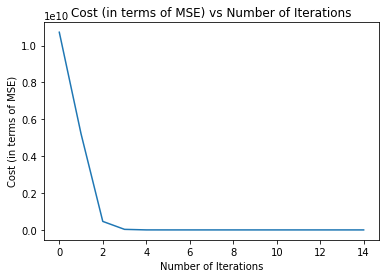

In [9]:
P_op, Cost, it_conv = GN(P_init,img_h,points_h,1000,1e-4)
P_op = P_gt[-1,-1]*P_op/P_op[-1,-1] 

print("\nFinal MSE = ",Cost[it_conv])
print("\niterations to converge = ",it_conv+1)
print("\nP_Output = ")
print(P_op)

plt.clf()
plt.plot(range(it_conv+1), Cost[0:it_conv+1])
plt.title('Cost (in terms of MSE) vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (in terms of MSE)')
plt.show()

## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

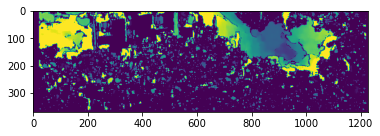

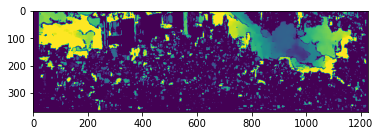

In [10]:
imgL = cv2.imread('../data/img2/0000000460.png',0)
imgR = cv2.imread('../data/img3/0000000460.png',0)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity)
plt.show()

imgL = cv2.imread('../data/img2/0000000461.png',0)
imgR = cv2.imread('../data/img3/0000000461.png',0)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity)
plt.show()

In [11]:
%matplotlib tk
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np

image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('../data/img2/0000000460.png')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

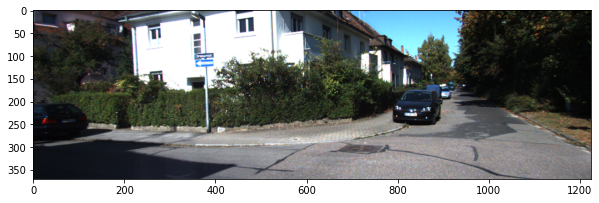

In [12]:
%matplotlib inline

N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('../data/img2/0000000460.png')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

print(image_points)
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()